## Adam convergence problem

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

We will solve the online optimization problem for function  $f_t(x) = \begin{cases} 1010x, \text{for t mod 101} = 1 \\ 
-10x, otherwise \end{cases}$

Online optimization task: $ F(x) = \sum_t f_t(x)  \to min_x$

with the constraint set $\mathcal{F} =[-1, 1]$

The analitical solution for this task is $x^*=-1$

In order to understand the problems of Adam, we denote the concept of "regret": $R_T = \sum\limits_{t=1}^T f_t(x_t) - \min\limits_{x \in \mathcal{F}} \sum\limits_{t=1}^T f_t(x)$

The regret should tend to zero during optimization, it implies that on average,
the model’s performance converges to the optimal one.

In [2]:
loss_buffer = []

In [48]:
import adashift.optimizers as ad_opt

In [4]:
def online_f_t(x, t):
    if t % 101 == 1:
        return 1010.0*x
    else:
        return -10.0*x
    
def f_min(t):
    if t % 101 == 1:
        return -1010.0
    else:
        return 10.0

In [5]:
def OnlineLearning(optimizer_type='Adam', start_lr=1, lr_decay=True, eps=0.,
                   x_init=0.0, betas=(0.9, 0.99), amsgrad=False, max_step = 1000001):
    x = torch.tensor([x_init], requires_grad=True)
    lr = start_lr
    if optimizer_type == "Adam":
        optimizer = torch.optim.Adam([x], amsgrad=amsgrad, lr=lr, betas=betas, eps=eps)
    else:
        optimizer = ad_opt.AdaShift([x], lr=lr, betas=betas, eps=eps)
    
    
    regret_sum = 0
    time_steps = []
    avg_regret_history = []
    x_history = []
    
    if lr_decay:
        lambda_lr_decay = lambda step: start_lr / np.sqrt(step + 1) 
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_lr_decay)

    for step in range(1, max_step):
        # constraint
        x.data = x.data.clamp(-1, 1)
        
        loss = online_f_t(x, step)

        regret_sum += (loss.item() - f_min(step))
        regret_avg = regret_sum / step
    
        loss.backward()
        
        x_history.append(x.item())

        if step % 10000 == 0:
            time_steps.append(step)
            avg_regret_history.append(regret_avg)
        if step % 50000 == 0:
            print('step : {} loss: {} regret_avg : {} x: {}'.format(step, loss.item() , regret_avg, x.item()))

        optimizer.step()
                                
        if lr_decay:
            scheduler.step()
        optimizer.zero_grad()
                                                      
    return time_steps, avg_regret_history, x_history

In [6]:
time_steps, avg_regret_history, x_history = OnlineLearning()

step : 50000 loss: -9.889703750610352 regret_avg : 0.5064160437881574 x: 0.9889703989028931
step : 100000 loss: -9.864534378051758 regret_avg : 0.4067958796649985 x: 0.9864534735679626
step : 150000 loss: -9.865385055541992 regret_avg : 0.36496171242752423 x: 0.9865384697914124
step : 200000 loss: -9.87474250793457 regret_avg : 0.34069642169266007 x: 0.9874742031097412
step : 250000 loss: -9.886850357055664 regret_avg : 0.32442571966003625 x: 0.9886850118637085
step : 300000 loss: -9.899446487426758 regret_avg : 0.3125654876726804 x: 0.9899446368217468
step : 350000 loss: -9.911629676818848 regret_avg : 0.3034359073735933 x: 0.9911629557609558
step : 400000 loss: -9.92305850982666 regret_avg : 0.2961329248513235 x: 0.9923058152198792
step : 450000 loss: -9.933679580688477 regret_avg : 0.29012170080303734 x: 0.9933679699897766
step : 500000 loss: -9.943526268005371 regret_avg : 0.2850632473994456 x: 0.9943526387214661
step : 550000 loss: -9.952676773071289 regret_avg : 0.280731002208641

In [7]:
amsgrad_time_steps, amsgrad_avg_regret_history, amsgrad_x_history = OnlineLearning(amsgrad=True)

step : 50000 loss: 9.866371154785156 regret_avg : 0.31438381194114684 x: -0.9866371154785156
step : 100000 loss: 9.961386680603027 regret_avg : 0.21818181499004363 x: -0.9961386919021606
step : 150000 loss: 9.991243362426758 regret_avg : 0.17665848134676615 x: -0.9991243481636047
step : 200000 loss: 10.0 regret_avg : 0.1522245525431633 x: -1.0
step : 250000 loss: 9.999848365783691 regret_avg : 0.13568643005943298 x: -0.999984860420227
step : 300000 loss: 9.997462272644043 regret_avg : 0.12354937993208567 x: -0.9997462034225464
step : 350000 loss: 9.993610382080078 regret_avg : 0.11415799653870719 x: -0.9993610382080078
step : 400000 loss: 9.989237785339355 regret_avg : 0.10661422948002815 x: -0.9989237785339355
step : 450000 loss: 9.984785079956055 regret_avg : 0.10038345542165968 x: -0.9984785318374634
step : 500000 loss: 9.980443954467773 regret_avg : 0.09512501832294463 x: -0.9980443716049194
step : 550000 loss: 9.976297378540039 regret_avg : 0.09061027578093789 x: -0.99762970209121

In [8]:
adashift_time_steps, adashift_avg_regret_history, adashift_x_history = OnlineLearning(optimizer_type='Adashift') 

step : 50000 loss: -9.65464973449707 regret_avg : 0.5204434230518341 x: 0.9654649496078491
step : 100000 loss: -9.76864242553711 regret_avg : 0.4226181678247452 x: 0.976864218711853
step : 150000 loss: -9.821847915649414 regret_avg : 0.3800128746064504 x: 0.9821847677230835
step : 200000 loss: -9.85526180267334 regret_avg : 0.35483106342077253 x: 0.9855261445045471
step : 250000 loss: -9.879294395446777 regret_avg : 0.3377391733531952 x: 0.9879294037818909
step : 300000 loss: -9.898001670837402 regret_avg : 0.3251710242509842 x: 0.9898001551628113
step : 350000 loss: -9.913345336914062 regret_avg : 0.3154315921660832 x: 0.9913344979286194
step : 400000 loss: -9.926398277282715 regret_avg : 0.30759905756115913 x: 0.9926398396492004
step : 450000 loss: -9.93781566619873 regret_avg : 0.3011235512998369 x: 0.993781566619873
step : 500000 loss: -9.948019027709961 regret_avg : 0.2956541783056259 x: 0.994801938533783
step : 550000 loss: -9.95728874206543 regret_avg : 0.29095510620203885 x: 0.

Regret should tend to zero. As we can see it is done only for amsgrad.

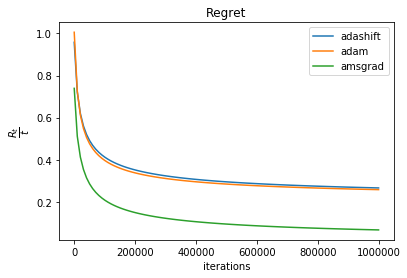

In [15]:
plt.title("Regret")
plt.plot(np.linspace(1, 1000001, 100), adashift_avg_regret_history, label='adashift')
plt.plot(np.linspace(1, 1000001, 100), avg_regret_history,label='adam')
plt.plot(np.linspace(1, 1000001, 100), amsgrad_avg_regret_history,label='amsgrad')
plt.xlabel("iterations")
plt.ylabel(r"$\dfrac{R_t}{t}$")
plt.legend()
plt.show()

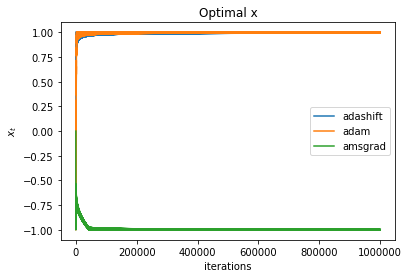

In [16]:
plt.title("Optimal x")
plt.plot(adashift_x_history, label='adashift')
plt.plot(x_history,label='adam')
plt.plot(amsgrad_x_history,label='amsgrad')
plt.legend()
plt.xlabel("iterations")
plt.ylabel(r"$x_t$")
plt.show()

Let's see on the similar task, but with stochasticity.

$\delta = 0.002$
C = 101

$f_t(x) = \begin{cases} Cx, \text{with p } =\frac{1+\delta}{C+1} \\ 
-x, otherwise \end{cases}$

Cost function is $\delta x$

In [69]:
delta = 0.02
C = 101
p = (1+delta)/(C + 1)

def stoch_f_t(x, t):
    if np.random.binomial(1,p):
        return C*x
    else:
        return -x
    

def domain_constraints(x):
    if x > 1.0:
        return x_max
    if x < -1.0:
        return x_min
    return x

def cost_f(x):
    return delta*x

In [77]:
def StochLearning(optimizer_type='Adam',alpha=1,lr_decay=True,\
                  amsgrad=False, max_step = 1000001, betas=(0.0, 0.999)):
    x = torch.tensor([0.0], requires_grad=True)
    if optimizer_type == "Adam":
        optimizer = torch.optim.Adam([x], lr=learning_rate, betas=betas, eps=0, amsgrad=amsgrad)
    else:
        optimizer = ad_opt.AdaShift([x], lr=learning_rate, betas=betas, eps=0)

    time_steps = []
    avg_regret_history = []
    x_history = []
    loss_history = []
    print("Optimization with {}".format(optimizer_type))
    
    if lr_decay:
        lambda_lr_decay = lambda step: alpha / np.sqrt(step + 1) 
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_lr_decay)

    
    for step in range(1, max_step):
        #x.data = x.data.clamp(-1.0, 1.0)

        loss = stoch_f_t(x, step)

        loss.backward()
        x_history.append(x.item())
        loss_history.append(loss.item())
        time_steps.append(step)

        if step % 15000 == 0:
            print ('step : ',step, '  loss : ',loss.item(), ' x:', x.item() )
                                 
        optimizer.step()   

        if lr_decay:
            scheduler.step()
        
        optimizer.zero_grad()
            
    return time_steps, loss_history, x_history

In [86]:
lr = 1e-3
time_steps, loss_history, x_history = StochLearning(alpha=lr, lr_decay=False, max_step=5000000)

Optimization with Adam
step :  15000   loss :  -0.24821510910987854  x: 0.24821510910987854
step :  30000   loss :  -0.35253000259399414  x: 0.35253000259399414
step :  45000   loss :  -0.5506541728973389  x: 0.5506541728973389
step :  60000   loss :  -0.7764875292778015  x: 0.7764875292778015
step :  75000   loss :  -0.9290183782577515  x: 0.9290183782577515
step :  90000   loss :  -1.0512555837631226  x: 1.0512555837631226
step :  105000   loss :  -1.0301158428192139  x: 1.0301158428192139
step :  120000   loss :  -0.9604437947273254  x: 0.9604437947273254
step :  135000   loss :  -1.0945324897766113  x: 1.0945324897766113
step :  150000   loss :  -1.1106010675430298  x: 1.1106010675430298
step :  165000   loss :  -0.816611111164093  x: 0.816611111164093
step :  180000   loss :  -0.6709068417549133  x: 0.6709068417549133
step :  195000   loss :  -0.6946277022361755  x: 0.6946277022361755
step :  210000   loss :  -1.0073158740997314  x: 1.0073158740997314
step :  225000   loss :  -0.9

step :  1845000   loss :  -9.1624755859375  x: 9.1624755859375
step :  1860000   loss :  -9.325246810913086  x: 9.325246810913086
step :  1875000   loss :  -9.177590370178223  x: 9.177590370178223
step :  1890000   loss :  -9.322919845581055  x: 9.322919845581055
step :  1905000   loss :  -9.386752128601074  x: 9.386752128601074
step :  1920000   loss :  -9.444437980651855  x: 9.444437980651855
step :  1935000   loss :  -9.434059143066406  x: 9.434059143066406
step :  1950000   loss :  -9.365593910217285  x: 9.365593910217285
step :  1965000   loss :  -9.183221817016602  x: 9.183221817016602
step :  1980000   loss :  -9.221536636352539  x: 9.221536636352539
step :  1995000   loss :  -9.155853271484375  x: 9.155853271484375
step :  2010000   loss :  -9.345288276672363  x: 9.345288276672363
step :  2025000   loss :  -9.497453689575195  x: 9.497453689575195
step :  2040000   loss :  -9.705366134643555  x: 9.705366134643555
step :  2055000   loss :  -9.614792823791504  x: 9.614792823791504

step :  3660000   loss :  -14.52509880065918  x: 14.52509880065918
step :  3675000   loss :  -14.574378967285156  x: 14.574378967285156
step :  3690000   loss :  -14.725659370422363  x: 14.725659370422363
step :  3705000   loss :  -14.701434135437012  x: 14.701434135437012
step :  3720000   loss :  -14.778724670410156  x: 14.778724670410156
step :  3735000   loss :  -14.723859786987305  x: 14.723859786987305
step :  3750000   loss :  -14.754409790039062  x: 14.754409790039062
step :  3765000   loss :  -14.726122856140137  x: 14.726122856140137
step :  3780000   loss :  -14.893620491027832  x: 14.893620491027832
step :  3795000   loss :  -14.835607528686523  x: 14.835607528686523
step :  3810000   loss :  -14.707511901855469  x: 14.707511901855469
step :  3825000   loss :  -14.85171127319336  x: 14.85171127319336
step :  3840000   loss :  -15.118491172790527  x: 15.118491172790527
step :  3855000   loss :  -15.198476791381836  x: 15.198476791381836
step :  3870000   loss :  -15.31527805

In [84]:
adashift_time_steps, adashift_loss_history, adashift_x_history = \
                    StochLearning(optimizer_type='Adashift',lr_decay=False, max_step=5000000)

Optimization with Adashift
step :  15000   loss :  -0.01907835714519024  x: 0.01907835714519024
step :  30000   loss :  0.03748631104826927  x: -0.03748631104826927
step :  45000   loss :  21.7471981048584  x: 0.21531879901885986
step :  60000   loss :  -0.3745274543762207  x: 0.3745274543762207
step :  75000   loss :  -0.5392547249794006  x: 0.5392547249794006
step :  90000   loss :  -0.5102288126945496  x: 0.5102288126945496
step :  105000   loss :  45.326541900634766  x: 0.4487776458263397
step :  120000   loss :  -0.3079794943332672  x: 0.3079794943332672
step :  135000   loss :  -0.23329365253448486  x: 0.23329365253448486
step :  150000   loss :  -0.2047886699438095  x: 0.2047886699438095
step :  165000   loss :  -0.23182785511016846  x: 0.23182785511016846
step :  180000   loss :  -0.34187474846839905  x: 0.34187474846839905
step :  195000   loss :  -0.4074649214744568  x: 0.4074649214744568
step :  210000   loss :  -0.43043556809425354  x: 0.43043556809425354
step :  225000   l

step :  1845000   loss :  -5.628382205963135  x: 5.628382205963135
step :  1860000   loss :  -5.7604899406433105  x: 5.7604899406433105
step :  1875000   loss :  -5.877578258514404  x: 5.877578258514404
step :  1890000   loss :  -6.218973636627197  x: 6.218973636627197
step :  1905000   loss :  -6.529513359069824  x: 6.529513359069824
step :  1920000   loss :  -6.645204544067383  x: 6.645204544067383
step :  1935000   loss :  -6.842708110809326  x: 6.842708110809326
step :  1950000   loss :  -6.798501968383789  x: 6.798501968383789
step :  1965000   loss :  -6.796505928039551  x: 6.796505928039551
step :  1980000   loss :  -6.863345146179199  x: 6.863345146179199
step :  1995000   loss :  -6.962059020996094  x: 6.962059020996094
step :  2010000   loss :  -6.838414192199707  x: 6.838414192199707
step :  2025000   loss :  -6.938562393188477  x: 6.938562393188477
step :  2040000   loss :  -6.866867542266846  x: 6.866867542266846
step :  2055000   loss :  -6.940768718719482  x: 6.940768718

step :  3690000   loss :  -10.300579071044922  x: 10.300579071044922
step :  3705000   loss :  -10.370394706726074  x: 10.370394706726074
step :  3720000   loss :  -10.376996994018555  x: 10.376996994018555
step :  3735000   loss :  -10.66328239440918  x: 10.66328239440918
step :  3750000   loss :  -10.48876667022705  x: 10.48876667022705
step :  3765000   loss :  -10.459474563598633  x: 10.459474563598633
step :  3780000   loss :  -10.479809761047363  x: 10.479809761047363
step :  3795000   loss :  -10.433722496032715  x: 10.433722496032715
step :  3810000   loss :  -10.669365882873535  x: 10.669365882873535
step :  3825000   loss :  -10.930485725402832  x: 10.930485725402832
step :  3840000   loss :  -11.027119636535645  x: 11.027119636535645
step :  3855000   loss :  -11.027254104614258  x: 11.027254104614258
step :  3870000   loss :  -11.30699348449707  x: 11.30699348449707
step :  3885000   loss :  -11.319656372070312  x: 11.319656372070312
step :  3900000   loss :  -11.3289270401

In [85]:
ams_time_steps, ams_loss_history, ams_x_history = StochLearning(alpha=lr, amsgrad=True, lr_decay=False, max_step=5000000)

Optimization with Adam
step :  15000   loss :  -0.39203155040740967  x: 0.39203155040740967
step :  30000   loss :  -0.29378440976142883  x: 0.29378440976142883
step :  45000   loss :  -0.21246397495269775  x: 0.21246397495269775
step :  60000   loss :  -0.2723574936389923  x: 0.2723574936389923
step :  75000   loss :  -0.24302639067173004  x: 0.24302639067173004
step :  90000   loss :  -0.2509249746799469  x: 0.2509249746799469
step :  105000   loss :  -0.1026228815317154  x: 0.1026228815317154
step :  120000   loss :  0.03075488470494747  x: -0.03075488470494747
step :  135000   loss :  -0.051459603011608124  x: 0.051459603011608124
step :  150000   loss :  -0.17082937061786652  x: 0.17082937061786652
step :  165000   loss :  0.014604401774704456  x: -0.014604401774704456
step :  180000   loss :  0.10337505489587784  x: -0.10337505489587784
step :  195000   loss :  0.07318710535764694  x: -0.07318710535764694
step :  210000   loss :  0.10362626612186432  x: -0.10362626612186432
step 

step :  1815000   loss :  4.134329795837402  x: -4.134329795837402
step :  1830000   loss :  4.223383903503418  x: -4.223383903503418
step :  1845000   loss :  4.291322231292725  x: -4.291322231292725
step :  1860000   loss :  4.338144779205322  x: -4.338144779205322
step :  1875000   loss :  4.216041088104248  x: -4.216041088104248
step :  1890000   loss :  4.136168956756592  x: -4.136168956756592
step :  1905000   loss :  4.007497310638428  x: -4.007497310638428
step :  1920000   loss :  4.096551418304443  x: -4.096551418304443
step :  1935000   loss :  4.171528339385986  x: -4.171528339385986
step :  1950000   loss :  4.147964954376221  x: -4.147964954376221
step :  1965000   loss :  4.075131416320801  x: -4.075131416320801
step :  1980000   loss :  3.9194164276123047  x: -3.9194164276123047
step :  1995000   loss :  3.899394989013672  x: -3.899394989013672
step :  2010000   loss :  3.8371434211730957  x: -3.8371434211730957
step :  2025000   loss :  3.97900390625  x: -3.97900390625

step :  3660000   loss :  6.120895862579346  x: -6.120895862579346
step :  3675000   loss :  6.076216697692871  x: -6.076216697692871
step :  3690000   loss :  6.080807685852051  x: -6.080807685852051
step :  3705000   loss :  6.015012741088867  x: -6.015012741088867
step :  3720000   loss :  6.160375595092773  x: -6.160375595092773
step :  3735000   loss :  6.326854228973389  x: -6.326854228973389
step :  3750000   loss :  6.401831150054932  x: -6.401831150054932
step :  3765000   loss :  6.385306358337402  x: -6.385306358337402
step :  3780000   loss :  6.235048294067383  x: -6.235048294067383
step :  3795000   loss :  6.155176162719727  x: -6.155176162719727
step :  3810000   loss :  6.173844337463379  x: -6.173844337463379
step :  3825000   loss :  6.122126579284668  x: -6.122126579284668
step :  3840000   loss :  6.119678974151611  x: -6.119678974151611
step :  3855000   loss :  6.082038402557373  x: -6.082038402557373
step :  3870000   loss :  6.07255220413208  x: -6.072552204132

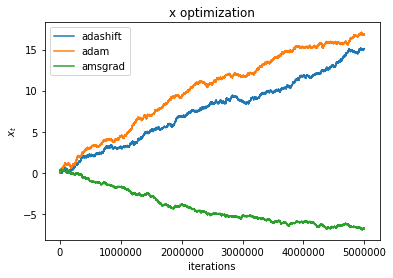

In [87]:
plt.title("x optimization")
plt.plot(adashift_x_history, label='adashift')
plt.plot(x_history,label='adam')
plt.plot(ams_x_history, label='amsgrad')
plt.legend()
plt.xlabel("iterations")
plt.ylabel(r"$x_t$")
plt.show()

#### Logistic regression on MNIST

In [35]:
import torchvision
import torchvision.transforms as transforms

input_size = 784
num_classes = 10
num_epochs = 5
batch_size = 128
learning_rate = 0.001

train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

Processing...
Done!


In [41]:
import torch.nn as nn

model = nn.Linear(input_size, num_classes)

criterion = nn.CrossEntropyLoss()

adam_optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,\
                             betas=(0.9, 0.99), eps=1e-8, weight_decay=0)

In [43]:
def train_model(model,criterion, optimizer):
    total_step = len(train_loader)
    loss_hist = []

    for epoch in range(num_epochs):
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.reshape(-1, 28*28)
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss_hist.append(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, batch_idx+1, total_step, loss.item()))
    return loss_hist

In [44]:
adam_loss_hist = train_model(model, criterion, adam_optimizer)

Epoch [1/5], Step [1/469], Loss: 2.2687
Epoch [1/5], Step [101/469], Loss: 0.7454
Epoch [1/5], Step [201/469], Loss: 0.6171
Epoch [1/5], Step [301/469], Loss: 0.5432
Epoch [1/5], Step [401/469], Loss: 0.3711
Epoch [2/5], Step [1/469], Loss: 0.5302
Epoch [2/5], Step [101/469], Loss: 0.3812
Epoch [2/5], Step [201/469], Loss: 0.3336
Epoch [2/5], Step [301/469], Loss: 0.4105
Epoch [2/5], Step [401/469], Loss: 0.3198
Epoch [3/5], Step [1/469], Loss: 0.2538
Epoch [3/5], Step [101/469], Loss: 0.2966
Epoch [3/5], Step [201/469], Loss: 0.2887
Epoch [3/5], Step [301/469], Loss: 0.2321
Epoch [3/5], Step [401/469], Loss: 0.2651
Epoch [4/5], Step [1/469], Loss: 0.1812
Epoch [4/5], Step [101/469], Loss: 0.2903
Epoch [4/5], Step [201/469], Loss: 0.3682
Epoch [4/5], Step [301/469], Loss: 0.1999
Epoch [4/5], Step [401/469], Loss: 0.2982
Epoch [5/5], Step [1/469], Loss: 0.2515
Epoch [5/5], Step [101/469], Loss: 0.1594
Epoch [5/5], Step [201/469], Loss: 0.3477
Epoch [5/5], Step [301/469], Loss: 0.2385
Ep

In [46]:
model = nn.Linear(input_size, num_classes)

criterion = nn.CrossEntropyLoss()

amsgrad_optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,\
                             betas=(0.9, 0.99), eps=1e-8, weight_decay=0,amsgrad=True)

ams_loss_hist = train_model(model, criterion, amsgrad_optimizer)

Epoch [1/5], Step [1/469], Loss: 2.3129
Epoch [1/5], Step [101/469], Loss: 0.7497
Epoch [1/5], Step [201/469], Loss: 0.5527
Epoch [1/5], Step [301/469], Loss: 0.3873
Epoch [1/5], Step [401/469], Loss: 0.3741
Epoch [2/5], Step [1/469], Loss: 0.3965
Epoch [2/5], Step [101/469], Loss: 0.3368
Epoch [2/5], Step [201/469], Loss: 0.3231
Epoch [2/5], Step [301/469], Loss: 0.3286
Epoch [2/5], Step [401/469], Loss: 0.2998
Epoch [3/5], Step [1/469], Loss: 0.2921
Epoch [3/5], Step [101/469], Loss: 0.3372
Epoch [3/5], Step [201/469], Loss: 0.3200
Epoch [3/5], Step [301/469], Loss: 0.2950
Epoch [3/5], Step [401/469], Loss: 0.3556
Epoch [4/5], Step [1/469], Loss: 0.2234
Epoch [4/5], Step [101/469], Loss: 0.3888
Epoch [4/5], Step [201/469], Loss: 0.2573
Epoch [4/5], Step [301/469], Loss: 0.2937
Epoch [4/5], Step [401/469], Loss: 0.2395
Epoch [5/5], Step [1/469], Loss: 0.2106
Epoch [5/5], Step [101/469], Loss: 0.2355
Epoch [5/5], Step [201/469], Loss: 0.3712
Epoch [5/5], Step [301/469], Loss: 0.3334
Ep

In [49]:
model = nn.Linear(input_size, num_classes)

criterion = nn.CrossEntropyLoss()

adashift_optimizer = ad_opt.AdaShift(model.parameters(), lr=1e-3,\
                             betas=(0.0, 0.99), eps=1e-8)

adashift_loss_hist = train_model(model, criterion, adashift_optimizer)

Epoch [1/5], Step [1/469], Loss: 2.3321
Epoch [1/5], Step [101/469], Loss: 1.4465
Epoch [1/5], Step [201/469], Loss: 1.0807
Epoch [1/5], Step [301/469], Loss: 0.8524
Epoch [1/5], Step [401/469], Loss: 0.7565
Epoch [2/5], Step [1/469], Loss: 0.6515
Epoch [2/5], Step [101/469], Loss: 0.5573
Epoch [2/5], Step [201/469], Loss: 0.5489
Epoch [2/5], Step [301/469], Loss: 0.6696
Epoch [2/5], Step [401/469], Loss: 0.6332
Epoch [3/5], Step [1/469], Loss: 0.3607
Epoch [3/5], Step [101/469], Loss: 0.5934
Epoch [3/5], Step [201/469], Loss: 0.3756
Epoch [3/5], Step [301/469], Loss: 0.4932
Epoch [3/5], Step [401/469], Loss: 0.4231
Epoch [4/5], Step [1/469], Loss: 0.3594
Epoch [4/5], Step [101/469], Loss: 0.3689
Epoch [4/5], Step [201/469], Loss: 0.4349
Epoch [4/5], Step [301/469], Loss: 0.3094
Epoch [4/5], Step [401/469], Loss: 0.4228
Epoch [5/5], Step [1/469], Loss: 0.3735
Epoch [5/5], Step [101/469], Loss: 0.3209
Epoch [5/5], Step [201/469], Loss: 0.3687
Epoch [5/5], Step [301/469], Loss: 0.2852
Ep

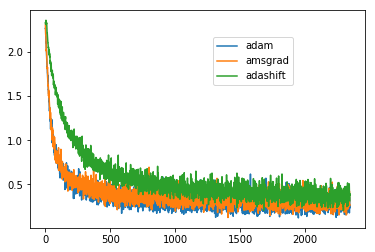

In [52]:
plt.plot(adam_loss_hist, label="adam")
plt.plot(ams_loss_hist, label="amsgrad")
plt.plot(adashift_loss_hist, label="adashift")

plt.legend(bbox_to_anchor=(0.8, 0.9), loc='best')
plt.show()